# Migrating from LLMMathChain

[`LLMMathChain`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.llm_math.base.LLMMathChain.html) enabled the evaluation of mathematical expressions generated by a LLM. Instructions for generating the expressions were formatted into the prompt, and the expressions were parsed out of the string response before evaluation using the [numexpr](https://numexpr.readthedocs.io/en/latest/user_guide.html) library.

This is more naturally achieved via [tool calling](/docs/concepts/tool_calling). We can equip a chat model with a simple calculator tool leveraging `numexpr` and construct a simple chain around it using [LangGraph](https://langchain-ai.github.io/langgraph/). Some advantages of this approach include:

- Leverage tool-calling capabilities of chat models that have been fine-tuned for this purpose;
- Reduce parsing errors from extracting expression from a string LLM response;
- Delegation of instructions to [message roles](/docs/concepts/messages) (e.g., chat models can understand what a `ToolMessage` represents without the need for additional prompting);
- Support for streaming, both of individual tokens and chain steps.

In [ ]:
%pip install --upgrade --quiet numexpr

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass()

## Legacy

<details open>

In [1]:
from langchain.chains import LLMMathChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

chain = LLMMathChain.from_llm(llm)

chain.invoke("What is 551368 divided by 82?")

{'question': 'What is 551368 divided by 82?', 'answer': 'Answer: 6724.0'}

</details>

## LangGraph

<details open>

In [2]:
import math
from typing import Annotated, Sequence

import numexpr
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode
from typing_extensions import TypedDict


@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = [calculator]
llm_with_tools = llm.bind_tools(tools, tool_choice="any")


class ChainState(TypedDict):
    """LangGraph state."""

    messages: Annotated[Sequence[BaseMessage], add_messages]


async def acall_chain(state: ChainState, config: RunnableConfig):
    last_message = state["messages"][-1]
    response = await llm_with_tools.ainvoke(state["messages"], config)
    return {"messages": [response]}


async def acall_model(state: ChainState, config: RunnableConfig):
    response = await llm.ainvoke(state["messages"], config)
    return {"messages": [response]}


graph_builder = StateGraph(ChainState)
graph_builder.add_node("call_tool", acall_chain)
graph_builder.add_node("execute_tool", ToolNode(tools))
graph_builder.add_node("call_model", acall_model)
graph_builder.set_entry_point("call_tool")
graph_builder.add_edge("call_tool", "execute_tool")
graph_builder.add_edge("execute_tool", "call_model")
graph_builder.add_edge("call_model", END)
chain = graph_builder.compile()

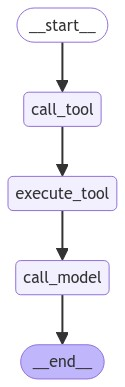

In [4]:
# Visualize chain:

from IPython.display import Image

Image(chain.get_graph().draw_mermaid_png())

In [5]:
# Stream chain steps:

example_query = "What is 551368 divided by 82"

events = chain.astream(
    {"messages": [("user", example_query)]},
    stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 551368 divided by 82
================================== Ai Message ==================================
Tool Calls:
  calculator (call_1ic3gjuII0Aq9vxlSYiwvjSb)
 Call ID: call_1ic3gjuII0Aq9vxlSYiwvjSb
  Args:
    expression: 551368 / 82
================================= Tool Message =================================
Name: calculator

6724.0
================================== Ai Message ==================================

551368 divided by 82 equals 6724.


</details>

## Next steps

See guides for building and working with tools [here](/docs/how_to/#tools).

Check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph.